# Utils

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [23]:
from lab1_utils import train_loop, train_loop_sched, save_to_json
from lab1_utils import multiple_diagnostic

Define 3 networks to test over the dataset

In [4]:
class Net1(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Linear(in_features, out_features, bias=True, device=None,
                            dtype=None)
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
                            padding=0, dilation=1, groups=1, bias=True,
                            padding_mode='zeros', device=None, dtype=None)
            torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1,
                               return_indices=False, ceil_mode=False)
        """
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        ## Network layers
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # output the logits

        ## Log-softmax for Negative-Log_likelihood
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        ## Network layers
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [6]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        # print(x.shape)
        ## Network layers
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        # la log(softmax) serve poi in fase di calcolo della CE loss
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = "MLP"
        self.fc1 = nn.Linear(28*28, 700)
        self.fc2 = nn.Linear(700, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
criterion = nn.NLLLoss()

In [14]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, transform=transform)

batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, num_workers=2, pin_memory=True, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, num_workers=2, pin_memory=True, shuffle=True, batch_size=batch_size)

In [31]:
model1 = Net1()
print(model1(torch.randn(1, 1, 28, 28)))
print(summary(model1))

tensor([[-2.3410, -2.4122, -2.3046, -2.2851, -2.4119, -2.2537, -2.2184, -2.2727,
         -2.2334, -2.3130]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net1                                     --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            1,179,776
├─Linear: 1-5                            1,290
├─ReLU: 1-6                              --
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0


In [22]:
model2 = Net2()
print(model2(torch.randn(1, 1, 28, 28)))
print(summary(model2))

tensor([[-2.1285, -2.3810, -2.1887, -2.2953, -2.5300, -2.0858, -2.4472, -2.3244,
         -2.3162, -2.4208]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net2                                     --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            204,928
├─Linear: 1-5                            1,290
├─ReLU: 1-6                              --
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0


In [42]:
model3 = Net3()
print(model3(torch.randn(1, 1, 28, 28)))
print(summary(model3))

torch.Size([1, 32, 12, 12])
tensor([[-2.2415, -2.1380, -2.3563, -2.2355, -2.3368, -2.3631, -2.3551, -2.3739,
         -2.2818, -2.3727]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net3                                     --
├─Conv2d: 1-1                            416
├─Conv2d: 1-2                            12,832
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            589,952
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
├─ReLU: 1-7                              --
Total params: 612,106
Trainable params: 612,106
Non-trainable params: 0


In [54]:
model4 = MLP()
print(model4(torch.randn(1, 1, 28, 28)))
print(summary(model4))

tensor([[-2.3185, -2.3295, -2.3295, -2.3295, -2.3295, -2.2693, -2.2505, -2.2408,
         -2.3295, -2.3049]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            549,500
├─Linear: 1-2                            350,500
├─Linear: 1-3                            125,250
├─Linear: 1-4                            2,510
├─ReLU: 1-5                              --
Total params: 1,027,760
Trainable params: 1,027,760
Non-trainable params: 0


# Exercise 0

In [10]:
max_epochs = 20
loss_acc_dict = {}

In [15]:
model1 = Net1()
model1.to(device)

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.)

stats = train_loop_sched(trainloader, testloader, model1, criterion, device,
                         optimizer, max_epochs=max_epochs)

loss_acc_dict["Net1"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.2626, Accuracy: 0.728, Runtime: 7.16
Test - Loss: 0.4372, Accuracy: 0.887
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.3868, Accuracy: 0.891, Runtime: 6.35
Test - Loss: 0.3231, Accuracy: 0.910
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.3231, Accuracy: 0.907, Runtime: 6.43
Test - Loss: 0.2892, Accuracy: 0.918
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.2919, Accuracy: 0.916, Runtime: 6.47
Test - Loss: 0.2629, Accuracy: 0.924
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.2667, Accuracy: 0.923, Runtime: 6.39
Test - Loss: 0.2470, Accuracy: 0.928
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2449, Accuracy: 0.930, Runtime: 6.48
Test - Loss: 0.2234, Accuracy: 0.934
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2255, Accuracy: 0.935, Runtime: 6.47
Test - Loss: 0.2087, Accuracy: 0.940
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2072, Accuracy: 0.941, Runtime: 6.48
Test - Loss: 0.1949, 

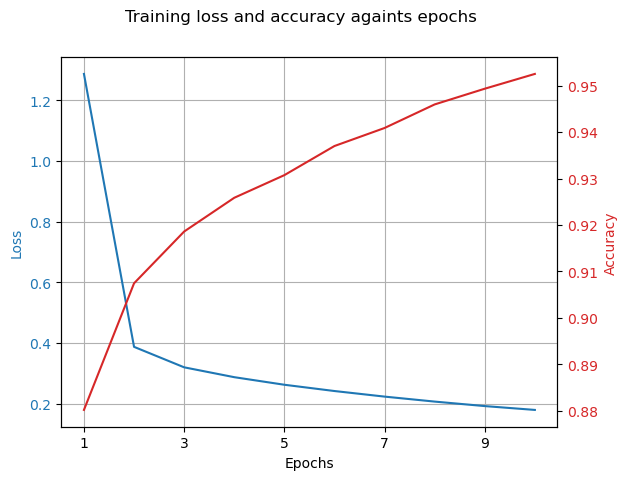

In [17]:
simple_diagnostic(10, stats[0], stats[3])

 # Exercise 1

Try different architectures

In [16]:
model2 = Net2()
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.)

stats = train_loop_sched(trainloader, testloader, model2, criterion, device,
                         optimizer, max_epochs=max_epochs)

loss_acc_dict["Net2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.1675, Accuracy: 0.413, Runtime: 5.64
Test - Loss: 1.8896, Accuracy: 0.714
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.2045, Accuracy: 0.776, Runtime: 5.58
Test - Loss: 0.6442, Accuracy: 0.852
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.5184, Accuracy: 0.863, Runtime: 5.41
Test - Loss: 0.4069, Accuracy: 0.892
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.3841, Accuracy: 0.891, Runtime: 5.30
Test - Loss: 0.3314, Accuracy: 0.905
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.3247, Accuracy: 0.906, Runtime: 5.49
Test - Loss: 0.2837, Accuracy: 0.919
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2858, Accuracy: 0.916, Runtime: 5.35
Test - Loss: 0.2569, Accuracy: 0.927
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2569, Accuracy: 0.924, Runtime: 5.37
Test - Loss: 0.2299, Accuracy: 0.934
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2330, Accuracy: 0.931, Runtime: 5.59
Test - Loss: 0.2135, 

In [17]:
model3 = Net3()
model3.to(device)

optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.)

stats = train_loop_sched(trainloader, testloader, model3, criterion, device,
                         optimizer, max_epochs=max_epochs)

loss_acc_dict["Net3"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.2686, Accuracy: 0.231, Runtime: 6.23
Test - Loss: 2.2000, Accuracy: 0.416
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.6405, Accuracy: 0.655, Runtime: 6.27
Test - Loss: 0.7031, Accuracy: 0.832
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.4918, Accuracy: 0.868, Runtime: 6.18
Test - Loss: 0.3776, Accuracy: 0.894
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.3615, Accuracy: 0.895, Runtime: 6.20
Test - Loss: 0.3160, Accuracy: 0.912
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.3171, Accuracy: 0.907, Runtime: 6.20
Test - Loss: 0.2796, Accuracy: 0.920
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2871, Accuracy: 0.916, Runtime: 6.16
Test - Loss: 0.2554, Accuracy: 0.926
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2626, Accuracy: 0.922, Runtime: 6.18
Test - Loss: 0.2337, Accuracy: 0.931
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2412, Accuracy: 0.929, Runtime: 6.24
Test - Loss: 0.2114, 

In [19]:
model4 = MLP()
model4.to(device)

optimizer = optim.SGD(model4.parameters(), lr=0.001, momentum=0.)

stats = train_loop_sched(trainloader, testloader, model4, criterion, device,
                         optimizer, max_epochs=max_epochs)

loss_acc_dict["MLP"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.2818, Accuracy: 0.294, Runtime: 5.17
Test - Loss: 2.2569, Accuracy: 0.431
Epoch: 2, Learning rate: 0.001000
Training - Loss: 2.2220, Accuracy: 0.449, Runtime: 5.21
Test - Loss: 2.1691, Accuracy: 0.453
Epoch: 3, Learning rate: 0.001000
Training - Loss: 2.0831, Accuracy: 0.463, Runtime: 5.04
Test - Loss: 1.9602, Accuracy: 0.482
Epoch: 4, Learning rate: 0.001000
Training - Loss: 1.8149, Accuracy: 0.505, Runtime: 5.30
Test - Loss: 1.6438, Accuracy: 0.531
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.5324, Accuracy: 0.553, Runtime: 5.81
Test - Loss: 1.4129, Accuracy: 0.573
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.3607, Accuracy: 0.582, Runtime: 5.19
Test - Loss: 1.2841, Accuracy: 0.594
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.2651, Accuracy: 0.595, Runtime: 5.15
Test - Loss: 1.2097, Accuracy: 0.604
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.2045, Accuracy: 0.603, Runtime: 5.16
Test - Loss: 1.1610, 

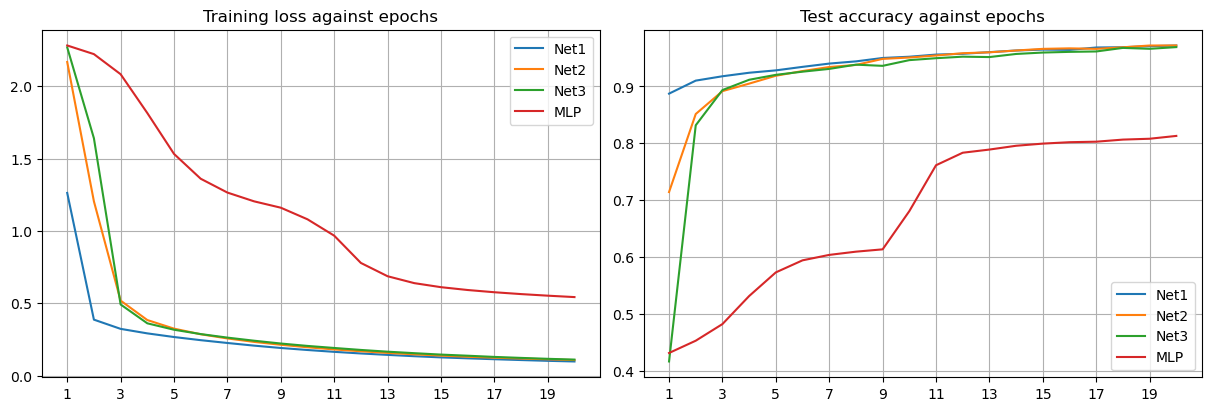

In [20]:
multiple_diagnostic(loss_acc_dict)
plt.savefig("./plots/mnist-benchmark-nets.pdf")

In [24]:
save_to_json(loss_acc_dict, "./plots/mnist-benchmark-nets.json")

# Exercise 2

Try different optimizers with Net2 architecture

In [25]:
sgd_dict = {}
sgd_dict["SGD"] = loss_acc_dict["Net2"]

Add momentum term

In [26]:
model2_2 = Net2()
model2_2.to(device)

optimizer = optim.SGD(model2_2.parameters(), lr=0.001, momentum=0.9)

stats = train_loop_sched(trainloader, testloader, model2_2, criterion, device,
                         optimizer, max_epochs=max_epochs)

sgd_dict["SGDM"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 0.6390, Accuracy: 0.821, Runtime: 5.37
Test - Loss: 0.1924, Accuracy: 0.945
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.1671, Accuracy: 0.951, Runtime: 5.28
Test - Loss: 0.1102, Accuracy: 0.967
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.1080, Accuracy: 0.968, Runtime: 5.20
Test - Loss: 0.0859, Accuracy: 0.975
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.0850, Accuracy: 0.974, Runtime: 6.69
Test - Loss: 0.0638, Accuracy: 0.981
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.0704, Accuracy: 0.980, Runtime: 5.56
Test - Loss: 0.0556, Accuracy: 0.983
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.0607, Accuracy: 0.982, Runtime: 5.36
Test - Loss: 0.0490, Accuracy: 0.984
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.0543, Accuracy: 0.984, Runtime: 5.35
Test - Loss: 0.0468, Accuracy: 0.984
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.0493, Accuracy: 0.985, Runtime: 5.47
Test - Loss: 0.0416, 

Change batch size

In [27]:
model2_3 = Net2()
model2_3.to(device)

optimizer = optim.SGD(model2_3.parameters(), lr=0.01, momentum=0.)

stats = train_loop_sched(trainloader, testloader, model2_3, criterion, device,
                         optimizer, max_epochs=max_epochs)

sgd_dict["SGD2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.5420, Accuracy: 0.848, Runtime: 5.39
Test - Loss: 0.1991, Accuracy: 0.940
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.1493, Accuracy: 0.956, Runtime: 6.04
Test - Loss: 0.1565, Accuracy: 0.949
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.0999, Accuracy: 0.970, Runtime: 6.02
Test - Loss: 0.1354, Accuracy: 0.956
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.0790, Accuracy: 0.976, Runtime: 5.64
Test - Loss: 0.0658, Accuracy: 0.979
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.0662, Accuracy: 0.980, Runtime: 5.60
Test - Loss: 0.0549, Accuracy: 0.984
Epoch: 6, Learning rate: 0.010000
Training - Loss: 0.0585, Accuracy: 0.983, Runtime: 5.72
Test - Loss: 0.0580, Accuracy: 0.981
Epoch: 7, Learning rate: 0.010000
Training - Loss: 0.0521, Accuracy: 0.985, Runtime: 5.56
Test - Loss: 0.0727, Accuracy: 0.977
Epoch: 8, Learning rate: 0.010000
Training - Loss: 0.0469, Accuracy: 0.986, Runtime: 5.53
Test - Loss: 0.0453, 

Increase learning rate

In [28]:
model2_4 = Net2()
model2_4.to(device)

optimizer = optim.SGD(model2_4.parameters(), lr=0.01, momentum=0.9)

stats = train_loop_sched(trainloader, testloader, model2_4, criterion, device,
                         optimizer, max_epochs=max_epochs)

sgd_dict["SGDM2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.1970, Accuracy: 0.939, Runtime: 5.88
Test - Loss: 0.0511, Accuracy: 0.983
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.0517, Accuracy: 0.985, Runtime: 6.09
Test - Loss: 0.0349, Accuracy: 0.988
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.0350, Accuracy: 0.989, Runtime: 5.77
Test - Loss: 0.0361, Accuracy: 0.988
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.0262, Accuracy: 0.992, Runtime: 5.44
Test - Loss: 0.0327, Accuracy: 0.988
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.0196, Accuracy: 0.994, Runtime: 5.37
Test - Loss: 0.0286, Accuracy: 0.991
Epoch: 6, Learning rate: 0.010000
Training - Loss: 0.0160, Accuracy: 0.995, Runtime: 5.36
Test - Loss: 0.0246, Accuracy: 0.992
Epoch: 7, Learning rate: 0.010000
Training - Loss: 0.0126, Accuracy: 0.996, Runtime: 5.41
Test - Loss: 0.0275, Accuracy: 0.991
Epoch: 8, Learning rate: 0.010000
Training - Loss: 0.0102, Accuracy: 0.997, Runtime: 5.57
Test - Loss: 0.0277, 

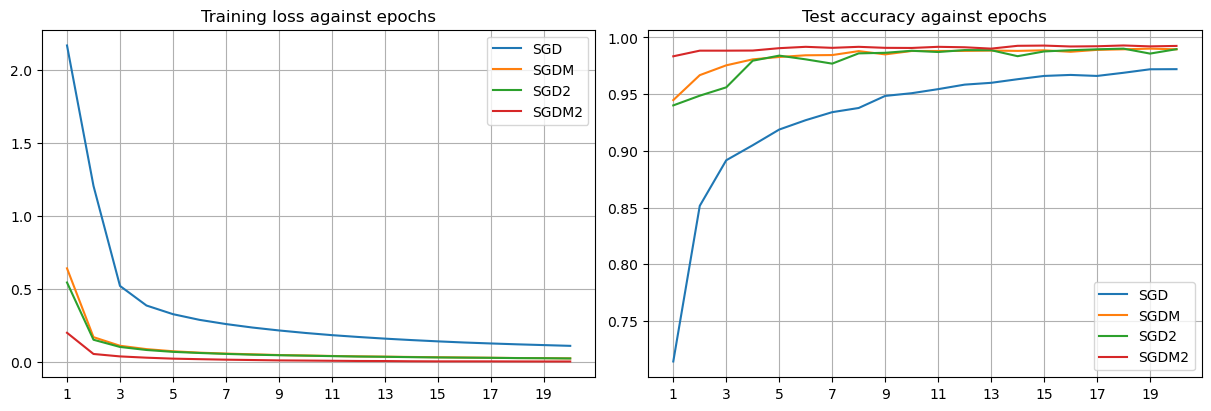

In [29]:
multiple_diagnostic(sgd_dict)
plt.savefig("./plots/mnist-benchmark-opts.pdf")

In [30]:
save_to_json(sgd_dict, "./plots/mnist-benchmark-opts.json")